![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 21 - Autoencoders</center>
### <center> Convolutional Autoencoders</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/21_Autoencoders/MainAutoEncoder.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

For Colab users:

In [3]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/21_Autoencoders/AutoencoderExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#-- Record figures during training:
from AutoencoderExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep, OneCycleScheduler

### Load MNIST data:

In [105]:
import torchvision.transforms as transforms
import torchvision

dataPath  = '../../data/'
oTrainSet = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=transforms.ToTensor(), download=True)
oTestSet  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=transforms.ToTensor(), download=True)

### Encoder:

In [31]:
import torch.nn as nn
import torchsummary

def GetEncoder():
    oEncoder = nn.Sequential(
#         nn.Sequential(),
        nn.Conv2d(1,  10, kernel_size=3, bias=False), nn.BatchNorm2d(10), nn.ReLU(), 
        nn.Conv2d(10, 20, kernel_size=3, bias=False), nn.BatchNorm2d(20), nn.ReLU(),
        nn.Conv2d(20, 40, kernel_size=3, bias=False), nn.BatchNorm2d(40), nn.ReLU(),
        nn.Conv2d(40, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 2,  kernel_size=1), 
    )
    
    return oEncoder

torchsummary.summary(GetEncoder(), (1, 28, 28), device='cpu')
print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          90
├─BatchNorm2d: 1-2                       [-1, 10, 26, 26]          20
├─ReLU: 1-3                              [-1, 10, 26, 26]          --
├─Conv2d: 1-4                            [-1, 20, 24, 24]          1,800
├─BatchNorm2d: 1-5                       [-1, 20, 24, 24]          40
├─ReLU: 1-6                              [-1, 20, 24, 24]          --
├─Conv2d: 1-7                            [-1, 40, 22, 22]          7,200
├─BatchNorm2d: 1-8                       [-1, 40, 22, 22]          80
├─ReLU: 1-9                              [-1, 40, 22, 22]          --
├─Conv2d: 1-10                           [-1, 60, 20, 20]          21,600
├─BatchNorm2d: 1-11                      [-1, 60, 20, 20]          120
├─ReLU: 1-12                             [-1, 60, 20,

### Decoder:

In [32]:
def GetDecoder():
    oDecoder = nn.Sequential(
#         nn.Sequential(),
        nn.Upsample(scale_factor=3), nn.Conv2d(2,  10, kernel_size=2, padding=1, bias=False), nn.BatchNorm2d(10), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(10, 20, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(20), nn.ReLU(), 
                                     nn.Conv2d(20, 30, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(30), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(30, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(40, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 40, kernel_size=3, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 1,  kernel_size=3),
        nn.Sigmoid(), 
    )

    return oDecoder

torchsummary.summary(GetDecoder(), (2, 1, 1), device='cpu')
print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Upsample: 1-1                          [-1, 2, 3, 3]             --
├─Conv2d: 1-2                            [-1, 10, 4, 4]            80
├─BatchNorm2d: 1-3                       [-1, 10, 4, 4]            20
├─ReLU: 1-4                              [-1, 10, 4, 4]            --
├─Upsample: 1-5                          [-1, 10, 8, 8]            --
├─Conv2d: 1-6                            [-1, 20, 8, 8]            1,800
├─BatchNorm2d: 1-7                       [-1, 20, 8, 8]            40
├─ReLU: 1-8                              [-1, 20, 8, 8]            --
├─Conv2d: 1-9                            [-1, 30, 8, 8]            5,400
├─BatchNorm2d: 1-10                      [-1, 30, 8, 8]            60
├─ReLU: 1-11                             [-1, 30, 8, 8]            --
├─Upsample: 1-12                         [-1, 30, 16, 16] 

### Full model (autoencoder):

In [33]:
def GetModel():
    oModel = nn.Sequential(GetEncoder(), GetDecoder())
    return oModel

torchsummary.summary(GetModel(), (1, 28, 28), device='cpu')
print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 10, 26, 26]          90
|    └─BatchNorm2d: 2-2                  [-1, 10, 26, 26]          20
|    └─ReLU: 2-3                         [-1, 10, 26, 26]          --
|    └─Conv2d: 2-4                       [-1, 20, 24, 24]          1,800
|    └─BatchNorm2d: 2-5                  [-1, 20, 24, 24]          40
|    └─ReLU: 2-6                         [-1, 20, 24, 24]          --
|    └─Conv2d: 2-7                       [-1, 40, 22, 22]          7,200
|    └─BatchNorm2d: 2-8                  [-1, 40, 22, 22]          80
|    └─ReLU: 2-9                         [-1, 40, 22, 22]          --
|    └─Conv2d: 2-10                      [-1, 60, 20, 20]          21,600
|    └─BatchNorm2d: 2-11                 [-1, 60, 20, 

### Data loaders, device, and loss function:

In [9]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=1)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=1)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [11]:
import torch.optim as optim
LossFunc = nn.MSELoss()

### Search learning rates:

<IPython.core.display.Javascript object>


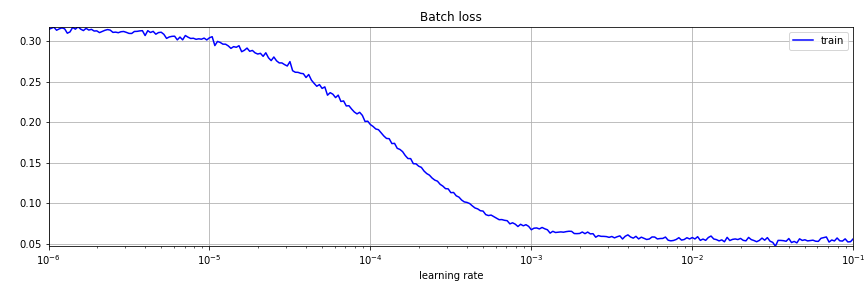

<IPython.core.display.Javascript object>


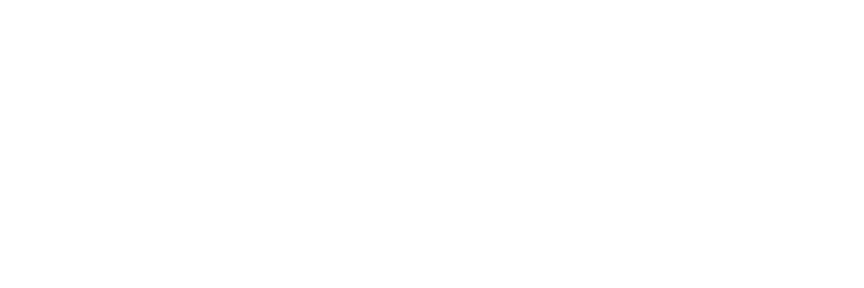

In [106]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-4)
vLearningRate = np.logspace(-6, -1, 301)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

In [107]:
%matplotlib inline
oRecorder.fig

NameError: name 'oRecorder' is not defined

### Train the model:

<IPython.core.display.Javascript object>


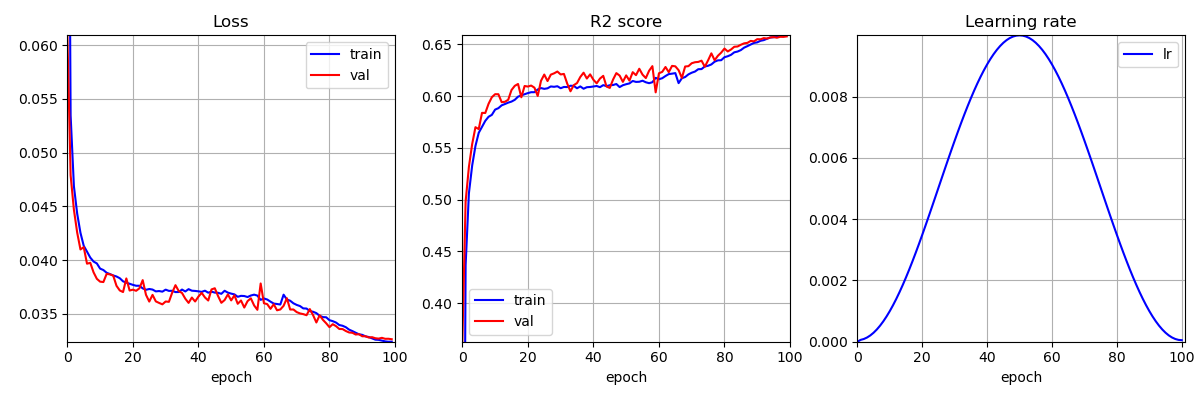

Epoch   0: | Train loss: 0.10492 | Val loss: 0.06090 | Train R2 score: -0.1055 | Val R2 score: 0.3628 | epoch time: 23.751 | <-- Checkpoint!
Epoch   1: | Train loss: 0.05345 | Val loss: 0.04789 | Train R2 score: 0.4367 | Val R2 score: 0.4982 | epoch time: 23.662 | <-- Checkpoint!
Epoch   2: | Train loss: 0.04688 | Val loss: 0.04469 | Train R2 score: 0.5061 | Val R2 score: 0.5316 | epoch time: 23.851 | <-- Checkpoint!
Epoch   3: | Train loss: 0.04432 | Val loss: 0.04256 | Train R2 score: 0.5329 | Val R2 score: 0.5536 | epoch time: 23.903 | <-- Checkpoint!
Epoch   4: | Train loss: 0.04254 | Val loss: 0.04099 | Train R2 score: 0.5518 | Val R2 score: 0.5699 | epoch time: 24.099 | <-- Checkpoint!
Epoch   5: | Train loss: 0.04133 | Val loss: 0.04120 | Train R2 score: 0.5645 | Val R2 score: 0.5681 | epoch time: 23.919 |
Epoch   6: | Train loss: 0.04079 | Val loss: 0.03966 | Train R2 score: 0.5702 | Val R2 score: 0.5837 | epoch time: 24.074 | <-- Checkpoint!
Epoch   7: | Train loss: 0.04023 | 

Epoch  64: | Train loss: 0.03591 | Val loss: 0.03533 | Train R2 score: 0.6216 | Val R2 score: 0.6291 | epoch time: 23.475 | <-- Checkpoint!
Epoch  65: | Train loss: 0.03586 | Val loss: 0.03540 | Train R2 score: 0.6221 | Val R2 score: 0.6287 | epoch time: 23.408 |
Epoch  66: | Train loss: 0.03678 | Val loss: 0.03574 | Train R2 score: 0.6124 | Val R2 score: 0.6249 | epoch time: 23.721 |
Epoch  67: | Train loss: 0.03633 | Val loss: 0.03645 | Train R2 score: 0.6172 | Val R2 score: 0.6175 | epoch time: 23.411 |
Epoch  68: | Train loss: 0.03622 | Val loss: 0.03540 | Train R2 score: 0.6183 | Val R2 score: 0.6285 | epoch time: 23.341 |
Epoch  69: | Train loss: 0.03598 | Val loss: 0.03540 | Train R2 score: 0.6209 | Val R2 score: 0.6288 | epoch time: 23.267 |
Epoch  70: | Train loss: 0.03583 | Val loss: 0.03516 | Train R2 score: 0.6225 | Val R2 score: 0.6316 | epoch time: 23.458 | <-- Checkpoint!
Epoch  71: | Train loss: 0.03572 | Val loss: 0.03504 | Train R2 score: 0.6236 | Val R2 score: 0.6326

In [13]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-2)

iterPerEpoch  = len(oTrainDL)
numEpochs     = 100
numIter       = numEpochs * iterPerEpoch
minLR         = 5e-5
maxLR         = 1e-2
vLearningRate = minLR + .5 * (maxLR - minLR) * (1 + np.cos(np.arange(numIter) / numIter * 2*np.pi + np.pi))

oScheduler = OneCycleScheduler(oOptim, vLearningRate)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim, oScheduler)

In [66]:
# torch.save(oModel.state_dict(), 'MainAutoEncoder1.pt')

In [108]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/21_Autoencoders/MainAutoEncoder1.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
#-- Run this to load a trained model:
# oModel = GetModel()
# oModel.load_state_dict(torch.load('MainAutoEncoder1.pt'))
# oModel.to(device)
# oModel.train(False)
# print()

### Apply the model to the (test set) data:

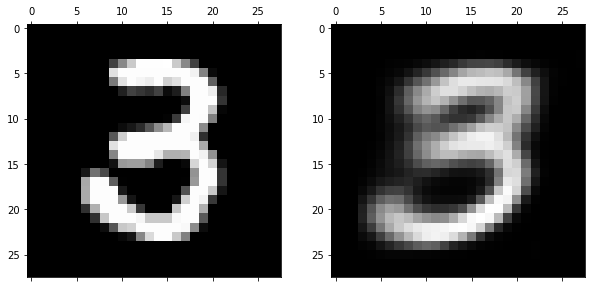

In [77]:
%matplotlib inline

# mX, _ = oTrainSet[np.random.randint(len(oTrainSet))]
mX, _ = oTestSet[np.random.randint(len(oTestSet))]
# mX    = torch.rand(*mX.shape)
mHatX = oModel(mX.unsqueeze(0).cuda()).squeeze(0)

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(mX.squeeze(), cmap='gray')
axs[1].matshow(mHatX.detach().cpu().squeeze(), cmap='gray')
plt.show()

### Encode the train\test data:

In [68]:
K         = 2000
oTrainDL2 = torch.utils.data.DataLoader(oTrainSet, shuffle=True, batch_size=K)
oTestDL2  = torch.utils.data.DataLoader(oTestSet,  shuffle=True, batch_size=K)

mTrainX, vTrainY = next(iter(oTrainDL2))
mTestX,  vTestY  = next(iter(oTestDL2))
oModel.to(device)

oEncoder = oModel[0]
mTrainZ  = oEncoder(mTrainX.to(device)).detach().cpu().numpy()
mTestZ   = oEncoder(mTestX.to (device)).detach().cpu().numpy()

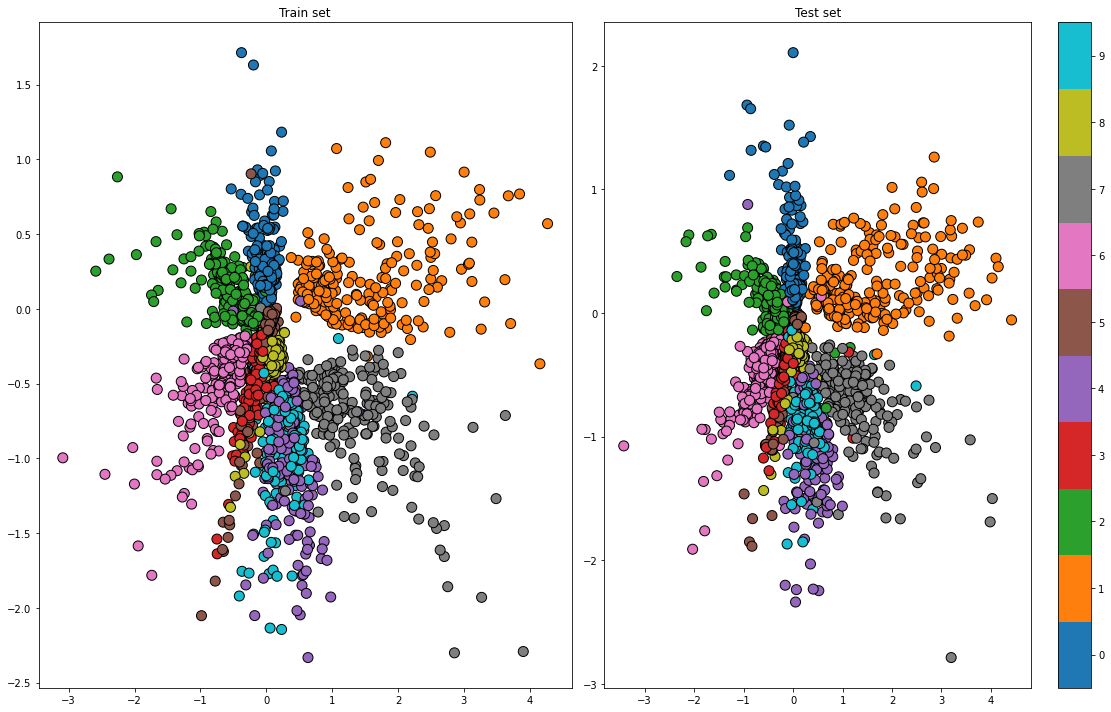

In [103]:
_, axes = plt.subplots(1, 2, figsize=(16, 10))
h1 = axes[0].scatter(mTrainZ[:,0], mTrainZ[:,1], s=100, c=vTrainY, edgecolor='k', cmap='tab10')
h2 = axes[1].scatter(mTestZ[:,0],  mTestZ[:,1],  s=100, c=vTestY,  edgecolor='k', cmap='tab10', vmin=-.5, vmax=9.5)
axes[0].set_title('Train set')
axes[1].set_title('Test set')
plt.colorbar(h2, ticks=range(10))
plt.tight_layout()
plt.show()

### Outliers:

In [79]:
K        = 500
oTestDL2 = torch.utils.data.DataLoader(oTestSet, shuffle=True, batch_size=K)
mX2, _   = next(iter(oTestDL2))

#-- Generate M outliers:
M              = 50 
mX2[-M:,:,:,:] = torch.randn(M, 1, 28, 28)

### Compute reconstruction error:

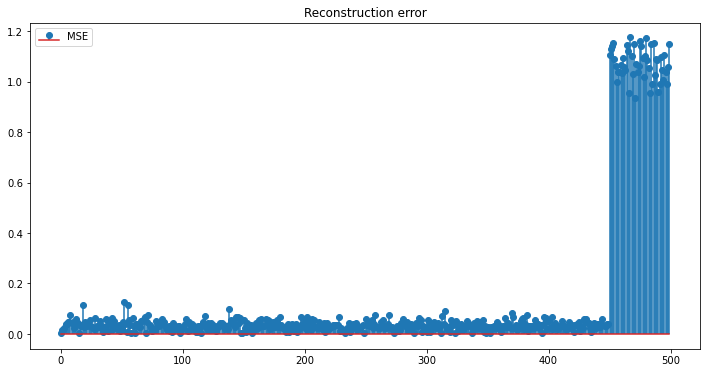

In [80]:
#-- Apply model:
mHatX2 = oModel(mX2.to(device)).cpu()
#-- Compute MSE:
vMSE   = torch.mean( (mHatX2.view(K, -1) - mX2.view(K, -1))**2, dim=1).detach()

plt.figure(figsize=(12, 6))
plt.stem(vMSE, use_line_collection=True, label='MSE')
plt.title('Reconstruction error')
plt.legend()
plt.show()

### Generate new samples:

<Figure size 432x288 with 0 Axes>

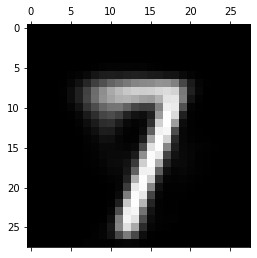

In [89]:
oDecoder = oModel[1]
oDecoder.to(device)

vZ    = torch.randn(1, 2, 1, 1)
mNewX = oDecoder(vZ.to(device)).squeeze().detach().cpu()

plt.figure()
plt.matshow(mNewX, cmap='gray')
plt.show()

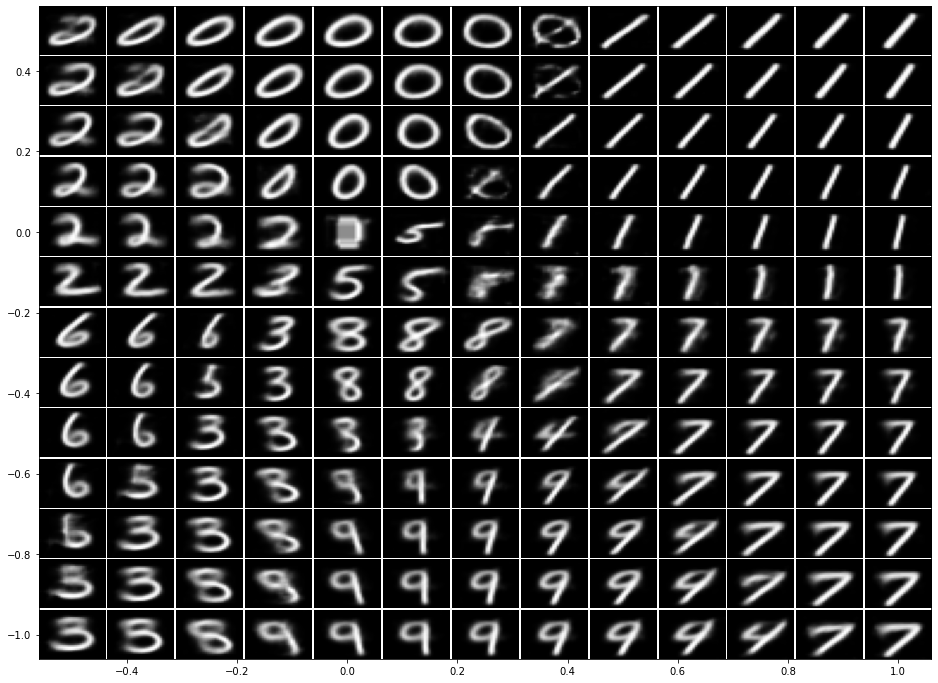

In [90]:
oDecoder   = oModel[1]
v1         = np.linspace(-1/2, 1,   13)
v2         = np.linspace(-1,   1/2, 13)
mZZ1, mZZ2 = np.meshgrid(v1, v2)
mZZ        = torch.tensor(np.c_[mZZ1.ravel(), mZZ2.ravel()], dtype=torch.float32).view(-1,2,1,1)
M          = mZZ.shape[0]
mHatX      = oDecoder(mZZ.to(device)).detach().cpu().squeeze()

fig = plt.figure(figsize=(16,12))
size = .06
for ii in range(M):

    x0  = mZZ[ii,0] - size
    x1  = mZZ[ii,0] + size
    y0  = mZZ[ii,1] - size
    y1  = mZZ[ii,1] + size
    plt.imshow(mHatX[ii,:,:], aspect='auto', cmap='gray', zorder=1, extent=(x0, x1, y0, y1))

plt.axis('tight')
plt.show()


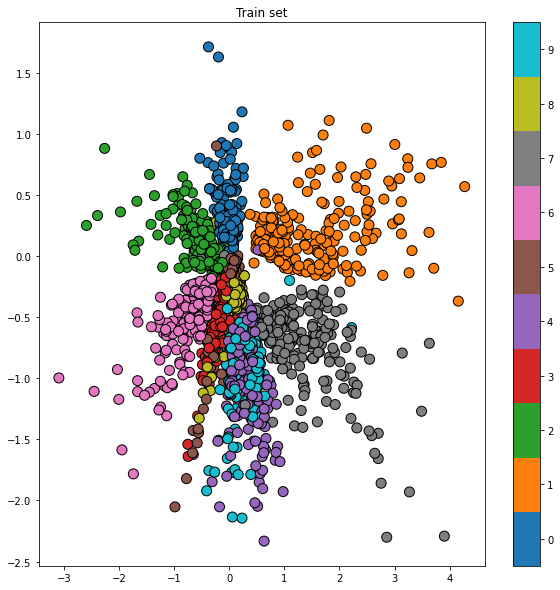

In [104]:
_, axes = plt.subplots(figsize=(10, 10))
h1 = axes.scatter(mTrainZ[:,0], mTrainZ[:,1], s=100, c=vTrainY, edgecolor='k', cmap='tab10', vmin=-.5, vmax=9.5)
axes.set_title('Train set')
plt.colorbar(h1, ticks=range(10))
plt.show()